In [1]:
# Install Packages
import sys
import os
from glob import glob
from six.moves import urllib
import tarfile
#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
#
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from skimage import io
from skimage import color
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import statistics
from itertools import cycle
#
import time
from tqdm import trange
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

## HPC Data Loading Check & Preparation 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/10243,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/10243,1), 'GB')

Using device: cuda
Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
# Check directory for data
! ls /inputOCT
! find /inputOCT | wc -l
! find /inputOCT/train | wc -l
! find /inputOCT/test | wc -l

test  train
109313
108310
1001


In [4]:
# Return a sorted list of image files at image_dir
def get_image_files(image_dir):
    fs = glob("{}/*.jpeg".format(image_dir))
    fs = [os.path.basename(filename) for filename in fs]
    return sorted(fs)

In [5]:
# HPC use - double checking image counts
data_train = get_image_files('/inputOCT/train')
data_test = get_image_files('/inputOCT/test')

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

print('Train Shape:', df_train.shape)
print('Test Shape:', df_test.shape)

Train Shape: (108309, 1)
Test Shape: (1000, 1)


In [6]:
# Correct number of images confirmed, set hpc image paths
train_image_path = '/inputOCT/train'
test_image_path = '/inputOCT/test'

In [7]:
# Labels CSV - generated outside HPC
labels_train = pd.read_csv('./OCTLabels/OCT_TrainLabels.csv')
labels_test = pd.read_csv('./OCTLabels/OCT_TestLabels.csv')

print(labels_train.shape)
print(labels_test.shape)

labels_train.head()

(108309, 3)
(1000, 3)


,0,Diagnosis,Class
0,NORMAL-1001772-1.jpeg,Normal,3
1,NORMAL-1001772-10.jpeg,Normal,3
2,NORMAL-1001772-11.jpeg,Normal,3
3,NORMAL-1001772-12.jpeg,Normal,3
4,NORMAL-1001772-13.jpeg,Normal,3


## Train and Validation Split

### Creating Subset CSVs for Training Experiments

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = labels_train

train_subset, val_subset = train_test_split(df, test_size=0.05, train_size = 0.2, random_state=42)

print(len(train_subset))
print('Selected subset class frequencies\n',train_subset['Diagnosis'].value_counts())
train_subset.to_csv('./OCTLabels/Train_Subset.csv',index=False)

print(len(val_subset))
print('Selected subset class frequencies\n',val_subset['Diagnosis'].value_counts())
val_subset.to_csv('./OCTLabels/Val_Subset.csv',index=False)

21661
Selected subset class frequencies
 Normal    10246
CNV        7490
DME        2194
DRUSEN     1731
Name: Diagnosis, dtype: int64
5416
Selected subset class frequencies
 Normal    2625
CNV       1807
DME        575
DRUSEN     409
Name: Diagnosis, dtype: int64


### Creating Fullset CSVs for Training Experiments

In [9]:
# Creating a Validation Set
import pandas as pd
from sklearn.model_selection import train_test_split

df = labels_train

train_subset, val_subset = train_test_split(df, test_size=0.2, train_size = 0.8, random_state=42)

print(len(train_subset))
print('Selected subset class frequencies\n',train_subset['Diagnosis'].value_counts())
train_subset.to_csv('./OCTLabels/Train_dataset_NEW.csv',index=False)

print(len(val_subset))
print('Selected subset class frequencies\n',val_subset['Diagnosis'].value_counts())
val_subset.to_csv('./OCTLabels/Val_dataset_NEW.csv',index=False)

86647
Selected subset class frequencies
 Normal    40823
CNV       29767
DME        9127
DRUSEN     6930
Name: Diagnosis, dtype: int64
21662
Selected subset class frequencies
 Normal    10317
CNV        7438
DME        2221
DRUSEN     1686
Name: Diagnosis, dtype: int64


# CNN Model 1
## ResNet-18 Without Attention (resnet18_WA) 

### ResNet18 DataLoader

In [10]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.RandomRotation(15),
                    transforms.RandomHorizontalFlip(),
                    transforms.Resize(512)])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(512)])
    
    
    
class Dataset_resnet18_WA(Dataset):

    def __init__(self, csv_file, root_dir, train = False):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.train = train

    def __len__(self):
        return len(self.data_frame)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 0])
        
        image = io.imread(img_name, as_gray = True)
        image = cv2.resize(image, (512,512))
        image = image.astype(float)
    
        # Normalization
        image -= np.mean(image)
        image /= np.maximum(np.std(image), 10**(-5))
        
        if self.train:
            image = train_transform(image)
        else:
            image = test_transform(image)
                
        image_class = self.data_frame.iloc[idx, -1]
            
        sample = {'image': image.float(), 'label': image_class}

        return sample

In [11]:
# Path to Fullsets
train_df_path = './OCTLabels/Train_dataset_NEW.csv'
val_df_path = './OCTLabels/Val_dataset_NEW.csv'
test_df_path = './OCTLabels/OCT_TestLabels.csv'

# Path to Subsets
#train_df_path = './OCTLabels/Train_Subset.csv'
#val_df_path = './OCTLabels/Val_Subset.csv'


transformed_dataset = {'train': Dataset_resnet18_WA(train_df_path, train_image_path, train = True),
                       'validate':Dataset_resnet18_WA(val_df_path, train_image_path, train = False)
                                          }
batch_size = 32
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=batch_size,
                        shuffle=True, num_workers=8, drop_last = False) for x in ['train', 'validate']}

In [12]:
sample = next(iter(dataloader['train']))

In [13]:
print(sample['image'].size())
print(sample['label'])

torch.Size([32, 1, 512, 512])
tensor([3, 0, 3, 0, 2, 3, 1, 0, 3, 3, 0, 3, 3, 1, 3, 3, 3, 0, 3, 3, 0, 1, 0, 0,
        0, 0, 3, 0, 2, 3, 3, 0])


In [14]:
sample['image'][3]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

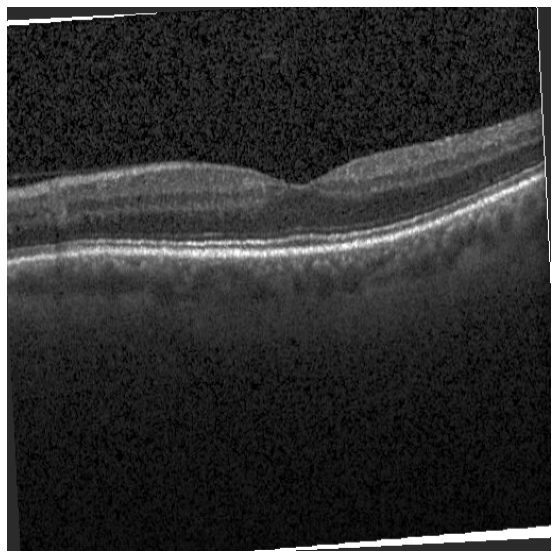

In [15]:
plt.figure(figsize=(10, 10));
plt.imshow(sample['image'][0][0].numpy(),cmap='gray');
plt.axis('off');

In [16]:
# Save model to directory
def save_model(model, best_model_wts, train_loss_return,train_acc_return,\
               val_loss_return, val_acc_return, save_name):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, save_name +'.pt')
    return None

### Train resnet18

In [17]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, verbose = False, save_name = 'model'):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    y_pred = []
    y_true = []
    
    for i in trange(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()

            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data['image'].to(device)
                label = data['label'].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
                if p== 'validate':
                    if i == num_epochs-1:
                        y_pred += preds.tolist()
                        y_true += label.tolist()
                       
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    save_model(model, best_model_wts, loss_dict['train'], acc_dict['train'],\
                       loss_dict['validate'], acc_dict['validate'], save_name=save_name)
    
    return model, acc_dict, loss_dict, y_pred, y_true

In [18]:
from torchvision import models as models
resnet18 = models.resnet18(pretrained = True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(512,4, bias = True)
resnet18_WA = resnet18
print(resnet18_WA)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
resnet18_WA = resnet18.to(device)
optimizer = torch.optim.Adam(resnet18_WA.parameters(), lr = 0.0003)

loss_fn = nn.CrossEntropyLoss()

model_resnet_WA, acc_dict, loss_dict, y_pred, y_true = train_model(resnet18_WA.to(device), dataloader, optimizer, loss_fn, num_epochs= 22, verbose = True, save_name = 'ResNet18_WA')



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 0/21
----------
Phase:train, epoch loss: 0.1606 Acc: 0.9459


  5%|▍         | 1/22 [09:13<3:13:47, 553.68s/it]

Phase:validate, epoch loss: 0.1164 Acc: 0.9599
Epoch: 1/21
----------
Phase:train, epoch loss: 0.1033 Acc: 0.9657


  9%|▉         | 2/22 [17:34<2:54:12, 522.64s/it]

Phase:validate, epoch loss: 0.0958 Acc: 0.9675
Epoch: 2/21
----------
Phase:train, epoch loss: 0.0914 Acc: 0.9696


 14%|█▎        | 3/22 [25:58<2:42:49, 514.20s/it]

Phase:validate, epoch loss: 0.0819 Acc: 0.9717
Epoch: 3/21
----------
Phase:train, epoch loss: 0.0825 Acc: 0.9722


 18%|█▊        | 4/22 [34:19<2:32:42, 509.04s/it]

Phase:validate, epoch loss: 0.0860 Acc: 0.9712
Epoch: 4/21
----------
Phase:train, epoch loss: 0.0754 Acc: 0.9742


 23%|██▎       | 5/22 [42:40<2:23:22, 506.03s/it]

Phase:validate, epoch loss: 0.0939 Acc: 0.9663
Epoch: 5/21
----------
Phase:train, epoch loss: 0.0690 Acc: 0.9768


 27%|██▋       | 6/22 [51:00<2:14:21, 503.85s/it]

Phase:validate, epoch loss: 0.0666 Acc: 0.9770
Epoch: 6/21
----------
Phase:train, epoch loss: 0.0644 Acc: 0.9775


 32%|███▏      | 7/22 [59:21<2:05:46, 503.11s/it]

Phase:validate, epoch loss: 0.0652 Acc: 0.9776
Epoch: 7/21
----------
Phase:train, epoch loss: 0.0612 Acc: 0.9787


 36%|███▋      | 8/22 [1:07:41<1:57:08, 502.07s/it]

Phase:validate, epoch loss: 0.0673 Acc: 0.9764
Epoch: 8/21
----------
Phase:train, epoch loss: 0.0581 Acc: 0.9801


 41%|████      | 9/22 [1:16:01<1:48:37, 501.31s/it]

Phase:validate, epoch loss: 0.0664 Acc: 0.9770
Epoch: 9/21
----------
Phase:train, epoch loss: 0.0538 Acc: 0.9809


 45%|████▌     | 10/22 [1:24:20<1:40:06, 500.54s/it]

Phase:validate, epoch loss: 0.0565 Acc: 0.9795
Epoch: 10/21
----------
Phase:train, epoch loss: 0.0503 Acc: 0.9829


 50%|█████     | 11/22 [1:32:37<1:31:35, 499.64s/it]

Phase:validate, epoch loss: 0.0562 Acc: 0.9796
Epoch: 11/21
----------
Phase:train, epoch loss: 0.0482 Acc: 0.9833


 55%|█████▍    | 12/22 [1:40:58<1:23:19, 499.90s/it]

Phase:validate, epoch loss: 0.0662 Acc: 0.9787
Epoch: 12/21
----------
Phase:train, epoch loss: 0.0457 Acc: 0.9844


 59%|█████▉    | 13/22 [1:49:09<1:14:34, 497.21s/it]

Phase:validate, epoch loss: 0.0585 Acc: 0.9804
Epoch: 13/21
----------
Phase:train, epoch loss: 0.0433 Acc: 0.9848


 64%|██████▎   | 14/22 [1:57:16<1:05:52, 494.07s/it]

Phase:validate, epoch loss: 0.0590 Acc: 0.9802
Epoch: 14/21
----------
Phase:train, epoch loss: 0.0416 Acc: 0.9852


 68%|██████▊   | 15/22 [2:05:25<57:28, 492.61s/it]  

Phase:validate, epoch loss: 0.0563 Acc: 0.9794
Epoch: 15/21
----------
Phase:train, epoch loss: 0.0390 Acc: 0.9861


 73%|███████▎  | 16/22 [2:13:36<49:13, 492.27s/it]

Phase:validate, epoch loss: 0.0515 Acc: 0.9827
Epoch: 16/21
----------
Phase:train, epoch loss: 0.0367 Acc: 0.9869


 77%|███████▋  | 17/22 [2:21:44<40:54, 490.97s/it]

Phase:validate, epoch loss: 0.0568 Acc: 0.9816
Epoch: 17/21
----------
Phase:train, epoch loss: 0.0369 Acc: 0.9872


 82%|████████▏ | 18/22 [2:30:02<32:52, 493.03s/it]

Phase:validate, epoch loss: 0.0601 Acc: 0.9797
Epoch: 18/21
----------
Phase:train, epoch loss: 0.0344 Acc: 0.9876


 86%|████████▋ | 19/22 [2:38:20<24:43, 494.44s/it]

Phase:validate, epoch loss: 0.0570 Acc: 0.9819
Epoch: 19/21
----------
Phase:train, epoch loss: 0.0334 Acc: 0.9882


 91%|█████████ | 20/22 [2:46:35<16:29, 494.61s/it]

Phase:validate, epoch loss: 0.0547 Acc: 0.9818
Epoch: 20/21
----------
Phase:train, epoch loss: 0.0310 Acc: 0.9891


 95%|█████████▌| 21/22 [2:54:48<08:14, 494.23s/it]

Phase:validate, epoch loss: 0.0558 Acc: 0.9818
Epoch: 21/21
----------
Phase:train, epoch loss: 0.0290 Acc: 0.9893


100%|██████████| 22/22 [3:03:00<00:00, 499.13s/it]

Phase:validate, epoch loss: 0.0567 Acc: 0.9821
Training complete in 183m 1s
Best val acc: 0.982689


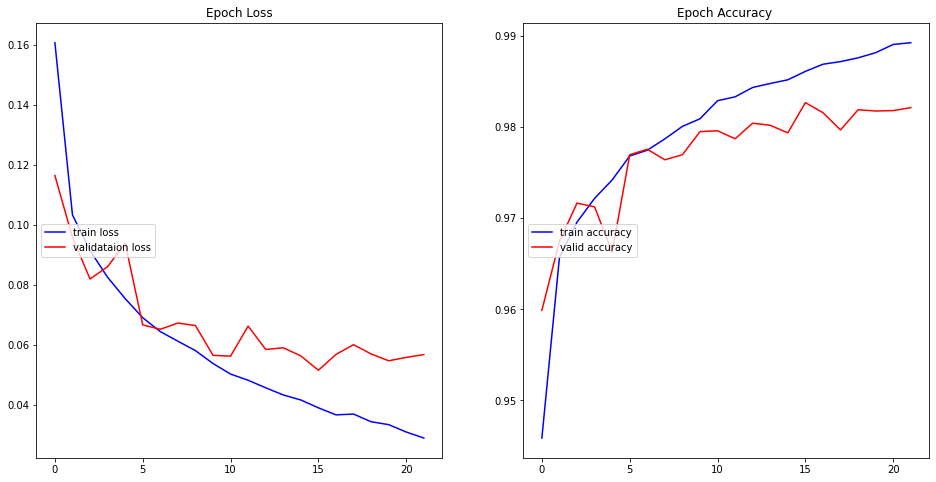

In [20]:
# Plotting loss and accuracy
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(loss_dict['train'], color='blue', label='train loss')
axs[0].plot(loss_dict['validate'], color='red', label='validataion loss')
axs[1].plot(acc_dict['train'], color = 'blue', label='train accuracy')
axs[1].plot(acc_dict['validate'], color = 'red', label='valid accuracy')
axs[0].set_title("Epoch Loss")
axs[1].set_title("Epoch Accuracy ")
axs[0].legend(loc='center left')
axs[1].legend(loc='center left')

In [21]:
print('Predicted Class:\n', y_pred[:10])
print('True Class:\n', y_true[:10])

Predicted Class:
 [0, 0, 3, 0, 0, 0, 1, 3, 0, 3]
True Class:
 [0, 0, 3, 0, 0, 0, 1, 3, 0, 3]


In [22]:
print('Average Train Loss:', statistics.mean(loss_dict['train']))
print('Average Validation Loss:', statistics.mean(loss_dict['validate']))
print('Average Train Accuracy:', statistics.mean(acc_dict['train']))
print('Average Validation Accuracy:', statistics.mean(acc_dict['validate']))

Average Train Loss: 0.058597133130201054
Average Validation Loss: 0.06749488354608993
Average Train Accuracy: 0.9798335356519714
Average Validation Accuracy: 0.9769894494758311


### Evaluate resnet18_WA

In [23]:
def evaluate_model(model, dataloader, loss_fn, phase = 'test'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    y_pred = [] # list of predicted classes
    y_true = [] # list of true classes
    pred_scores_list = [] # list of predicted class probabilities
    outputs =[]
    
    for i , (data) in enumerate(dataloader):
        image = data['image'].to(device)
        label = data['label'].to(device)
        output = model(image)
        loss = loss_fn(output, label)
        num_imgs = image.size()[0]
        outputs += output.cpu().detach().numpy().tolist()
        #
        pred_score = nn.Softmax(1)(output).cpu().detach().numpy()
        pred_scores_list = pred_score.tolist()
        #
        _, preds = torch.max(output,dim = 1)
        y_true += label.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()
        #
        running_correct += torch.sum(preds ==label).item()
        running_loss += loss.item()*num_imgs
        running_total += num_imgs
        
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
   
    
    return accuracy, loss, y_pred, np.array(y_true), np.array(pred_scores_list), np.array(outputs)

In [24]:
test_dataset = Dataset_resnet18_WA('./OCTLabels/OCT_TestLabels.csv', test_image_path , train = False)

batch_size = 32

dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,
                        num_workers=8, drop_last = False)

acc_resnet_WA, loss_resnet_WA, y_pred_resnet_WA, y_true_resnet_WA, pred_scores_resnet_WA, outputs = evaluate_model(model_resnet_WA.to(device), dataloader, loss_fn, phase = 'test')




In [25]:
print('Eval Loss:',loss_resnet_WA)
print('Eval Accuracy:', acc_resnet_WA)
print('True Class:',y_true_resnet_WA[:10])
print('Predicted Class:', y_pred_resnet_WA[:10])
print('Predicted Probability:\n',pred_scores_resnet_WA[:5])
print('Logits:\n', outputs[:5])

Eval Loss: 0.21073520396649836
Eval Accuracy: 0.959
True Class: [0 2 2 2 0 2 2 1 2 3]
Predicted Class: [0, 2, 2, 2, 0, 0, 2, 1, 2, 3]
Predicted Probability:
 [[4.34787211e-07 9.99878645e-01 3.94659935e-07 1.20551682e-04]
 [1.85128499e-06 2.79298365e-05 7.70270944e-01 2.29699284e-01]
 [3.12239339e-04 1.81970288e-04 1.69628474e-03 9.97809470e-01]
 [4.94912058e-01 1.94704000e-04 5.04709899e-01 1.83311044e-04]
 [2.66548228e-09 2.88238584e-06 9.48105844e-06 9.99987602e-01]]
Logits:
 [[ 11.03297901 -17.1023159   -7.02760124 -30.99026489]
 [  0.08881465 -11.28736019   2.59714961  -7.87644577]
 [ -3.47886443  -5.19597292   1.87435389  -0.40267518]
 [  0.44960737  -7.57130051   0.85934252  -3.5275023 ]
 [ 11.0905695  -14.71089458 -12.31007767 -30.13744164]]


Class 0 = AUC 0.974
Class 1 = AUC 0.9853333333333333
Class 2 = AUC 0.9319999999999999
Class 3 = AUC 0.9993333333333334


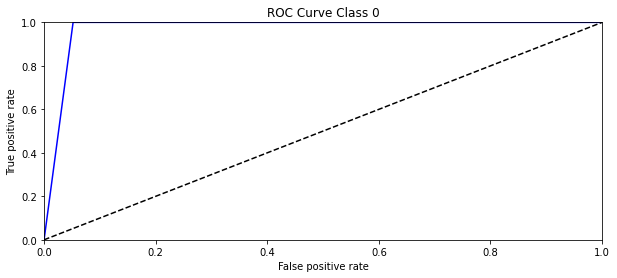

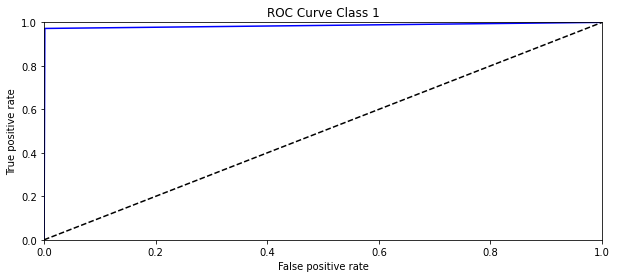

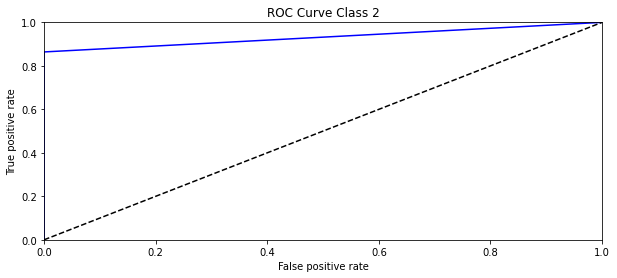

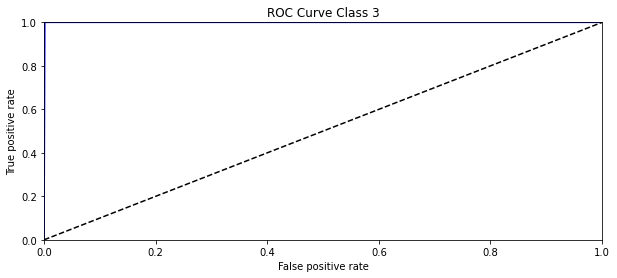

In [26]:
# Plot ROC
classes = range(len(np.unique(y_pred_resnet_WA)))

def label_binarize_classes(classes, a):
    label_class = []
    for label in classes:
        if label == a:
            label_class.append(1)
        else:
            label_class.append(0)
    return label_class

for i in classes:
    true_labels_test = label_binarize_classes(y_true_resnet_WA, i)
    pred_labels_test = label_binarize_classes(y_pred_resnet_WA, i)
    fpr, tpr, thresholds = roc_curve(true_labels_test, pred_labels_test)
    auc = roc_auc_score(true_labels_test, pred_labels_test)

    print('Class ' + str(i),'=','AUC ' + str(auc))
    
    plt.figure(figsize=(10,4))
    plt.title('ROC Curve Class '+str(i))
    plt.plot(fpr,tpr,color ='blue')
    plt.plot([0,1],[0,1],"k--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

In [27]:
# Confusion Matrix
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
def cm(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    class_names = ['0: CNV','1: DME','2: DRUSEN','3: Normal']
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix')

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.03 0.97 0.   0.  ]
 [0.13 0.   0.86 0.  ]
 [0.   0.   0.   1.  ]]


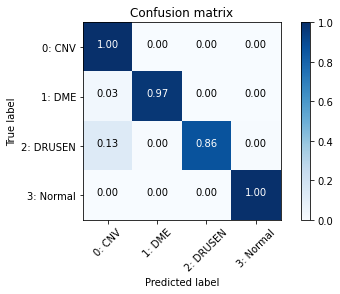

In [28]:
# Plot Confusion Matrix - ResNet_WA
cm(y_true_resnet_WA, y_pred_resnet_WA)

In [29]:
from sklearn.metrics import classification_report
class_names = ['0: CNV','1: DME','2: DRUSEN','3: Normal']

ResnetWA_classificationreport = classification_report(y_true_resnet_WA, y_pred_resnet_WA, target_names = class_names)
print(ResnetWA_classificationreport)

              precision    recall  f1-score   support

      0: CNV       0.87      1.00      0.93       250
      1: DME       1.00      0.97      0.98       250
   2: DRUSEN       1.00      0.86      0.93       250
   3: Normal       1.00      1.00      1.00       250

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



# CNN Model 2
## ResNet-18 with Attention (resnet_CBAM)

### resnet_CBAM dataloader

In [14]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.RandomRotation(15),
                    transforms.RandomHorizontalFlip(),
                    transforms.Resize(512)])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(512)])

class Dataset_resnet_CBAM(Dataset):

    def __init__(self, csv_file, root_dir, train = False):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.train = train

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 0])
        
        image = io.imread(img_name, as_gray = True)
        image = cv2.resize(image, (512,512))
        image = image.astype(float)
    
        # Normalization
        image -= np.mean(image)
        image /= np.maximum(np.std(image), 10**(-5))
        
        if self.train:
            image = train_transform(image)
        else:
            image = test_transform(image)
                
        image_class = self.data_frame.iloc[idx, -1]
            
        sample = {'image': image.float(), 'label': image_class}

        return sample

In [15]:
# Path to full dataset 
train_df_path = './OCTLabels/Train_dataset_NEW.csv'
val_df_path = './OCTLabels/Val_dataset_NEW.csv'
test_df_path = './OCTLabels/OCT_TestLabels.csv'

# Path to subset
#train_df_path = './OCTLabels/Train_Subset.csv'
#val_df_path = './OCTLabels/Val_Subset.csv'


transformed_dataset = {'train': Dataset_resnet_CBAM(train_df_path, train_image_path, train = True),
                       'validate':Dataset_resnet_CBAM(val_df_path, train_image_path, train = False)
                                          }
batch_size = 32
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=batch_size,
                        shuffle=True, num_workers=8, drop_last = False) for x in ['train', 'validate']}

In [16]:
sample = next(iter(dataloader['train']))

In [17]:
print(sample['image'].size())
print(sample['label'])

torch.Size([32, 1, 512, 512])
tensor([3, 0, 0, 0, 0, 1, 3, 3, 0, 0, 3, 0, 0, 0, 2, 3, 0, 3, 0, 3, 3, 3, 3, 0,
        3, 2, 3, 3, 3, 0, 0, 0])


In [18]:
sample['image'][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

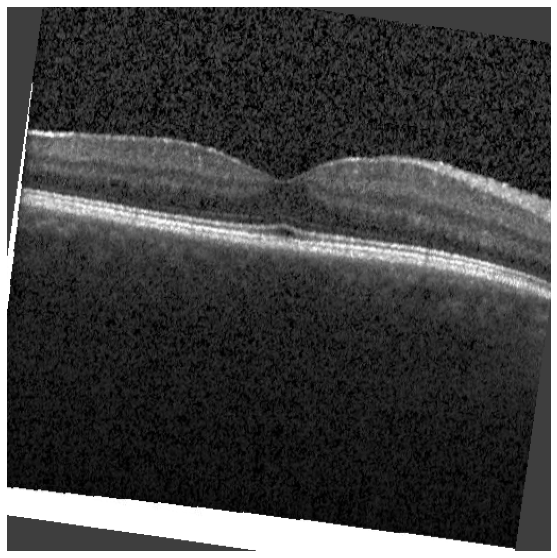

In [19]:

plt.figure(figsize=(10, 10));
plt.imshow(sample['image'][0][0].numpy(),cmap='gray');
plt.axis('off');

In [20]:
def save_model(model, best_model_wts, train_loss_return,train_acc_return,\
               val_loss_return, val_acc_return, save_name):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, save_name+'.pt')
    return None

In [21]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, verbose = False, save_name = 'model'):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    y_pred = []
    y_true = []
    
    for i in trange(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()

            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data['image'].to(device)
                label = data['label'].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
                if p== 'validate':
                    if i == num_epochs-1:
                        y_pred += preds.tolist()
                        y_true += label.tolist()
                       
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    save_model(model, best_model_wts, loss_dict['train'], acc_dict['train'],\
                       loss_dict['validate'], acc_dict['validate'], save_name=save_name)
    
    return model, acc_dict, loss_dict, y_pred, y_true

In [23]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18_cbam', 'resnet34_cbam', 'resnet50_cbam', 'resnet101_cbam',
           'resnet152_cbam']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1) # can experiment with CAM pool layers, both optimal
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7): # can experiment with SAM kernel size, k = 7 optimal
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet34_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet34'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet50_cbam(pretrained= False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet50'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model

In [24]:
print(resnet18_cbam(pretrained= False))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [25]:
model_CBAM = resnet18_cbam(pretrained= True).to(device)
model_CBAM.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_CBAM.fc = nn.Linear(512,4, bias = True)

optimizer = torch.optim.Adam(model_CBAM.parameters(), lr = 0.0003)

loss_fn = nn.CrossEntropyLoss()

model_resnet_CBAM, acc_dict, loss_dict, y_pred, y_true = train_model(model_CBAM.to(device), dataloader, optimizer, loss_fn, num_epochs= 22, verbose = True, save_name='model_resnet50_CBAM')


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 0/21
----------
Phase:train, epoch loss: 0.2031 Acc: 0.9309


  5%|▍         | 1/22 [09:24<3:17:44, 564.99s/it]

Phase:validate, epoch loss: 0.1386 Acc: 0.9535
Epoch: 1/21
----------
Phase:train, epoch loss: 0.1095 Acc: 0.9623


  9%|▉         | 2/22 [18:10<3:00:37, 541.86s/it]

Phase:validate, epoch loss: 0.1032 Acc: 0.9645
Epoch: 2/21
----------
Phase:train, epoch loss: 0.0915 Acc: 0.9681


 14%|█▎        | 3/22 [26:58<2:49:35, 535.58s/it]

Phase:validate, epoch loss: 0.0840 Acc: 0.9710
Epoch: 3/21
----------
Phase:train, epoch loss: 0.0808 Acc: 0.9718


 18%|█▊        | 4/22 [35:47<2:39:51, 532.87s/it]

Phase:validate, epoch loss: 0.0826 Acc: 0.9718
Epoch: 4/21
----------
Phase:train, epoch loss: 0.0749 Acc: 0.9739


 23%|██▎       | 5/22 [44:35<2:30:31, 531.28s/it]

Phase:validate, epoch loss: 0.0830 Acc: 0.9719
Epoch: 5/21
----------
Phase:train, epoch loss: 0.0694 Acc: 0.9758


 27%|██▋       | 6/22 [53:23<2:21:19, 529.95s/it]

Phase:validate, epoch loss: 0.0724 Acc: 0.9744
Epoch: 6/21
----------
Phase:train, epoch loss: 0.0641 Acc: 0.9772


 32%|███▏      | 7/22 [1:02:09<2:12:12, 528.84s/it]

Phase:validate, epoch loss: 0.0630 Acc: 0.9788
Epoch: 7/21
----------
Phase:train, epoch loss: 0.0604 Acc: 0.9784


 36%|███▋      | 8/22 [1:10:58<2:03:22, 528.76s/it]

Phase:validate, epoch loss: 0.0583 Acc: 0.9778
Epoch: 8/21
----------
Phase:train, epoch loss: 0.0569 Acc: 0.9798


 41%|████      | 9/22 [1:19:44<1:54:22, 527.87s/it]

Phase:validate, epoch loss: 0.0564 Acc: 0.9793
Epoch: 9/21
----------
Phase:train, epoch loss: 0.0542 Acc: 0.9806


 45%|████▌     | 10/22 [1:28:30<1:45:27, 527.27s/it]

Phase:validate, epoch loss: 0.0580 Acc: 0.9794
Epoch: 10/21
----------
Phase:train, epoch loss: 0.0515 Acc: 0.9813


 50%|█████     | 11/22 [1:37:20<1:36:48, 528.06s/it]

Phase:validate, epoch loss: 0.0576 Acc: 0.9806
Epoch: 11/21
----------
Phase:train, epoch loss: 0.0494 Acc: 0.9819


 55%|█████▍    | 12/22 [1:46:09<1:28:04, 528.42s/it]

Phase:validate, epoch loss: 0.0932 Acc: 0.9701
Epoch: 12/21
----------
Phase:train, epoch loss: 0.0461 Acc: 0.9834


 59%|█████▉    | 13/22 [1:54:58<1:19:16, 528.48s/it]

Phase:validate, epoch loss: 0.0563 Acc: 0.9799
Epoch: 13/21
----------
Phase:train, epoch loss: 0.0453 Acc: 0.9836


 64%|██████▎   | 14/22 [2:03:45<1:10:25, 528.13s/it]

Phase:validate, epoch loss: 0.0571 Acc: 0.9796
Epoch: 14/21
----------
Phase:train, epoch loss: 0.0427 Acc: 0.9845


 68%|██████▊   | 15/22 [2:12:33<1:01:38, 528.29s/it]

Phase:validate, epoch loss: 0.0494 Acc: 0.9821
Epoch: 15/21
----------
Phase:train, epoch loss: 0.0413 Acc: 0.9849


 73%|███████▎  | 16/22 [2:21:21<52:49, 528.18s/it]  

Phase:validate, epoch loss: 0.0557 Acc: 0.9797
Epoch: 16/21
----------
Phase:train, epoch loss: 0.0388 Acc: 0.9860


 77%|███████▋  | 17/22 [2:30:10<44:01, 528.26s/it]

Phase:validate, epoch loss: 0.0524 Acc: 0.9817
Epoch: 17/21
----------
Phase:train, epoch loss: 0.0377 Acc: 0.9861


 82%|████████▏ | 18/22 [2:39:01<35:15, 528.98s/it]

Phase:validate, epoch loss: 0.0533 Acc: 0.9819
Epoch: 18/21
----------
Phase:train, epoch loss: 0.0368 Acc: 0.9865


 86%|████████▋ | 19/22 [2:47:52<26:29, 529.71s/it]

Phase:validate, epoch loss: 0.0559 Acc: 0.9806
Epoch: 19/21
----------
Phase:train, epoch loss: 0.0351 Acc: 0.9867


 91%|█████████ | 20/22 [2:56:43<17:39, 529.97s/it]

Phase:validate, epoch loss: 0.0483 Acc: 0.9838
Epoch: 20/21
----------
Phase:train, epoch loss: 0.0327 Acc: 0.9876


 95%|█████████▌| 21/22 [3:05:32<08:49, 529.91s/it]

Phase:validate, epoch loss: 0.0532 Acc: 0.9823
Epoch: 21/21
----------
Phase:train, epoch loss: 0.0327 Acc: 0.9879


100%|██████████| 22/22 [3:14:23<00:00, 530.16s/it]

Phase:validate, epoch loss: 0.0569 Acc: 0.9818
Training complete in 194m 23s
Best val acc: 0.983750


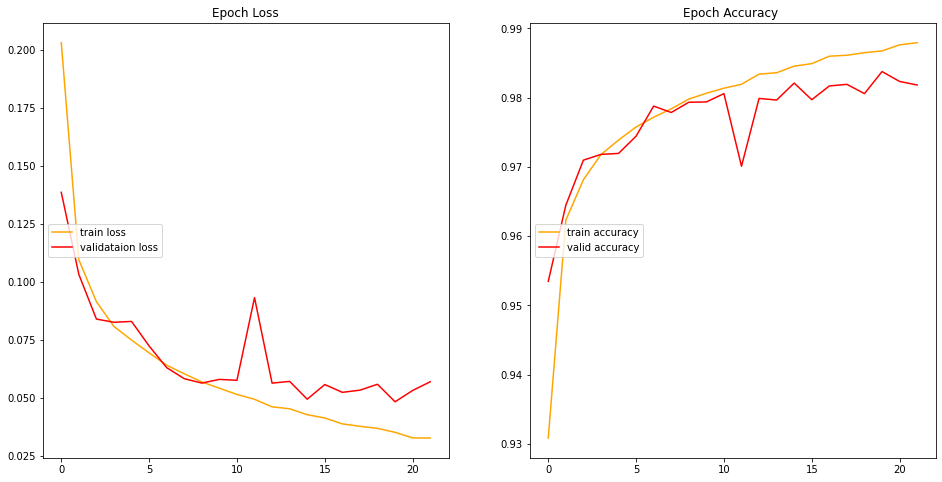

In [28]:
# Plotting loss and accuracy
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(loss_dict['train'], color='orange', label='train loss')
axs[0].plot(loss_dict['validate'], color='red', label='validataion loss')
axs[1].plot(acc_dict['train'], color = 'orange', label='train accuracy')
axs[1].plot(acc_dict['validate'], color = 'red', label='valid accuracy')
axs[0].set_title("Epoch Loss")
axs[1].set_title("Epoch Accuracy ")
axs[0].legend(loc='center left')
axs[1].legend(loc='center left')

In [29]:
print('Predicted Class:', y_pred[:20])
print('True Class:', y_true[:20])
print('Average Train Loss:', statistics.mean(loss_dict['train']))
print('Average Validation Loss:', statistics.mean(loss_dict['validate']))
print('Average Train Accuracy:', statistics.mean(acc_dict['train']))
print('Average Validation Accuracy:', statistics.mean(acc_dict['validate']))

Predicted Class: [3, 0, 1, 1, 3, 0, 3, 3, 0, 1, 0, 0, 3, 3, 0, 0, 1, 2, 3, 1]
True Class: [3, 0, 1, 1, 3, 0, 3, 3, 0, 1, 0, 0, 3, 3, 0, 0, 1, 2, 3, 1]
Average Train Loss: 0.06159066410431774
Average Validation Loss: 0.06767022205555856
Average Train Accuracy: 0.9781380460111403
Average Validation Accuracy: 0.9766495161195559


### Evaluate CBAM

In [30]:
def evaluate_model(model, dataloader, loss_fn, phase = 'test'):
    model.eval()
    
    running_correct = 0
    running_loss = 0
    running_total = 0
    y_hat = []
    y_true = []
    pred_scores = []
    pred_list = []
    y_test_label = []
    y_test = []
    y_score =[]
    
    for i , (data) in enumerate(dataloader):
        image = data['image'].to(device)
        label = data['label'].to(device)
        label = label.cpu()
        y_test_label = y_test_label+label.tolist()
        y_tests = label_binarize(label, classes=[0, 1, 2, 3])
        y_test += y_tests.tolist()
        output = model(image)
        output = output.cpu()
        y_scores = np.array(output.detach().numpy())
        y_score += y_scores.tolist()
        loss = loss_fn(output, label)
        _, preds = torch.max(output,dim = 1) # pred from model output
        pred_score = nn.Softmax(1)(output).cpu().detach().numpy()
        pred_scores += pred_score.tolist()
        num_imgs = image.size()[0]
        running_correct += torch.sum(preds ==label).item()
        running_loss += loss.item()*num_imgs
        running_total += num_imgs
        pred = np.argmax(pred_score, axis =1)
        pred_list += pred.tolist() # pred from softmax probablilites, SAME AS PREDS
        y_true += label.cpu().numpy().tolist()
        y_hat += preds.tolist()
        
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    
    return accuracy, loss, y_hat, y_true, pred_scores, pred_list, y_test_label, y_test, y_score

In [31]:
test_dataset = Dataset_resnet_CBAM('./OCTLabels/OCT_TestLabels.csv', test_image_path , train = False)

batch_size = 32

dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,
                        num_workers=8, drop_last = False)

acc_resnet_CBAM, loss_resnet_CBAM, y_pred_resnet_CBAM, y_true_model_resnet_CBAM, pred_scores_resnet_CBAM, pred_list_CBAM, y_test_label, y_test, y_score = evaluate_model(model_resnet_CBAM.to(device), dataloader, loss_fn, phase = 'test')



In [32]:
print('Eval Loss:', loss_resnet_CBAM)
print('Eval Acc:', acc_resnet_CBAM)
print('y_true_model_resnet_CBAM',y_true_model_resnet_CBAM[:10])
print('y_pred_resnet_CBAM',y_pred_resnet_CBAM[:10])
print('pred_scores_resnet_CBAM:\n',np.array(pred_scores_resnet_CBAM[:10])) # probability of each class
print('y_score:\n',np.array(y_score[:10])) # model output

Eval Loss: 0.1143890220746398
Eval Acc: 0.971
y_true_model_resnet_CBAM [2, 1, 0, 0, 2, 2, 3, 2, 1, 3]
y_pred_resnet_CBAM [2, 1, 0, 0, 2, 2, 3, 2, 1, 3]
pred_scores_resnet_CBAM:
 [[3.68487928e-03 1.39767435e-04 9.95698214e-01 4.77195223e-04]
 [1.78021714e-04 9.99350727e-01 9.21630914e-08 4.71198699e-04]
 [1.00000000e+00 1.27007311e-08 1.44463985e-09 5.97477103e-12]
 [9.99799907e-01 1.94139793e-04 2.64294613e-06 3.34493097e-06]
 [1.71179056e-01 1.01471145e-03 8.25644851e-01 2.16137059e-03]
 [7.17059989e-03 8.79553321e-04 9.88570392e-01 3.37954657e-03]
 [1.68715797e-08 3.83291450e-07 6.16295119e-06 9.99993443e-01]
 [4.19534184e-03 7.00159489e-06 9.95784819e-01 1.27866942e-05]
 [5.93897188e-04 9.78339791e-01 3.42215412e-06 2.10630056e-02]
 [3.20006919e-08 5.07137827e-07 4.41269179e-07 9.99999046e-01]]
y_score:
 [[ -2.94549561  -6.21750879   2.65371084  -4.98956299]
 [ -4.1113615    4.52159452 -11.67746258  -3.13798642]
 [  8.80515385  -9.37645149 -11.55025196 -17.03832245]
 [  4.24432707  

Class 0 = AUC 0.9813333333333334
Class 1 = AUC 0.984
Class 2 = AUC 0.958
Class 3 = AUC 0.9993333333333334


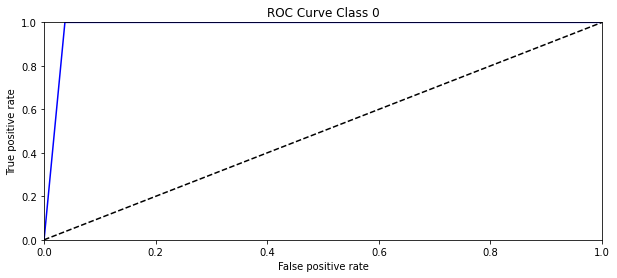

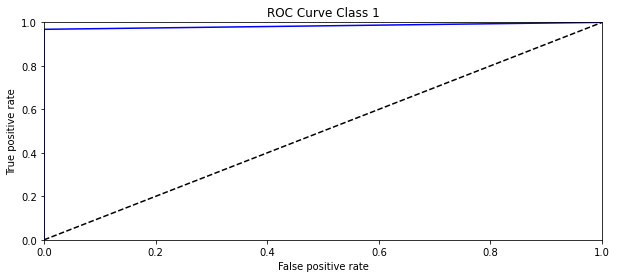

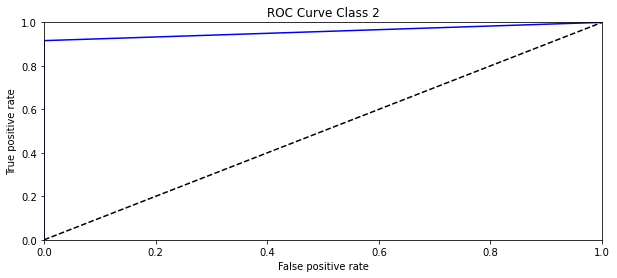

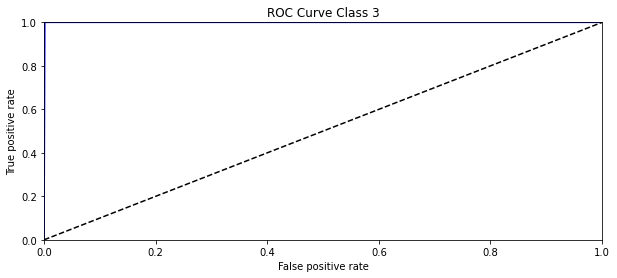

In [33]:
from sklearn.metrics import auc, roc_auc_score 

classes = range(len(np.unique(y_pred_resnet_CBAM)))

def label_binarize_classes(classes, a):
    label_class = []
    for label in classes:
        if label == a:
            label_class.append(1)
        else:
            label_class.append(0)
    return label_class

for i in classes:
    true_labels_test = label_binarize_classes(y_true_model_resnet_CBAM, i)
    pred_labels_test = label_binarize_classes(y_pred_resnet_CBAM, i)
    fpr, tpr, thresholds = roc_curve(true_labels_test, pred_labels_test)
    auc = roc_auc_score(true_labels_test, pred_labels_test)

    print('Class ' + str(i),'=','AUC ' + str(auc))
    
    plt.figure(figsize=(10,4))
    plt.title('ROC Curve Class '+str(i))
    plt.plot(fpr,tpr,color ='blue')
    plt.plot([0,1],[0,1],"k--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

In [34]:
# Confusion Matrix
from sklearn.metrics import  confusion_matrix, roc_curve, auc
import itertools  

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
def cm(y_true_model_resnet_WA, y_pred_resnet_WA):
    cnf_matrix = confusion_matrix(y_true_model_resnet_WA, y_pred_resnet_WA)
    np.set_printoptions(precision=2)
    plt.figure()
    class_names = ['0: CNV','1: DME','2: DRUSEN','3: Normal']
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix')

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.03 0.97 0.   0.  ]
 [0.08 0.   0.92 0.  ]
 [0.   0.   0.   1.  ]]


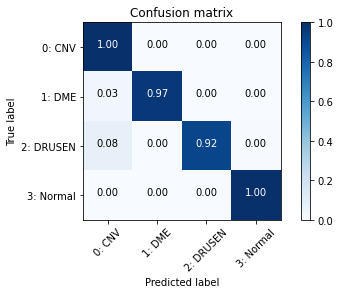

In [35]:
# Confusion Matrix for CNN_model_CXR0
cm(y_true_model_resnet_CBAM, y_pred_resnet_CBAM)

In [36]:
from sklearn.metrics import classification_report
class_names = ['0: CNV','1: DME','2: DRUSEN','3: Normal']

ResnetCBAM_classificationreport = classification_report(y_true_model_resnet_CBAM, y_pred_resnet_CBAM, target_names = class_names)
print(ResnetCBAM_classificationreport)

              precision    recall  f1-score   support

      0: CNV       0.90      1.00      0.95       250
      1: DME       1.00      0.97      0.98       250
   2: DRUSEN       1.00      0.92      0.96       250
   3: Normal       1.00      1.00      1.00       250

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

